In [292]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
from astropy import constants as const
from matplotlib import colors
PLOT_PARAMS()
import thejoker as tj

from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

05_13_25


In [2]:
galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [3]:
galah_vac = Table.read('../../lithium/data/GALAH_DR3_VAC_ages_v2.fits').to_pandas()

In [4]:
rv_df = pd.read_csv('comb_rvs.csv')

In [5]:
rv_df[(rv_df.program==113) & (rv_df.RG_id==7)]

,sobject_id,logg,teff,RG_id,galah_id,obj_name,esp_time,esp_rv,esp_rv_err,Li_val,...,dec_dr2,dr3_source_id,MJD_local,rv_nogr_obst,e_rv_nogr_obst,rv_galah,e_rv_galah,comb_time,comb_rv,comb_rv_err
15,160521004801082,1.486652,4504.8706,7,160521004801082,UCAC4 212-183136,"[2460455.84420948, 2460499.70978278, 2460515.8...","[6.64289216946065, 5.54159459550407, 5.2425269...","[0.0580769521431972, 0.0347318594592558, 0.050...",4.23,...,-47.697664,6668577437377879424,57529.76,5.913,0.225,5.895,0.226,[2460455.84420948 2460499.70978278 2460515.850...,[6.64289217 5.5415946 5.24252698 6.17836707 6...,[0.05807695 0.03473186 0.05003201 0.06260242 0...


In [6]:
binary_list_113 = 7, 9, 11, 16, 18, 19, 21, 23  
binary_list_112 = 6, 7, 13, 23

In [7]:
def load_samples(df0,program,binary_list):
    stat_dict = {}        
    version = 1
    
    df = df0[df0.program==program]
    
    dtemp = {'RG_id':[],
             'P16':[], 'P50':[], 'P84':[],
             'e16':[], 'e50':[], 'e84':[],
             'K16':[], 'K50':[], 'K84':[] }
    
    for i, row in df.iterrows():
        RG = row.RG_id
        
        if RG not in binary_list:
            continue
        fname = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,RG,version)

        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        Ks = mcmc_samples['K'].value
        
        dtemp['RG_id'].append(RG)
        
        dtemp['P16'].append(np.percentile(Ps, 16))
        dtemp['P50'].append(np.percentile(Ps, 50))
        dtemp['P84'].append(np.percentile(Ps, 84))
        
        dtemp['e16'].append(np.percentile(es, 16))
        dtemp['e50'].append(np.percentile(es, 50))
        dtemp['e84'].append(np.percentile(es, 84))
        
        dtemp['K16'].append(np.percentile(Ks, 16))
        dtemp['K50'].append(np.percentile(Ks, 50))
        dtemp['K84'].append(np.percentile(Ks, 84))
    
    dtemp = pd.DataFrame(dtemp)
    
    dtemp = pd.merge(dtemp, df)
    
    return dtemp

temp1 = load_samples(rv_df, 112, binary_list_112)
temp2 = load_samples(rv_df, 113, binary_list_113)


In [8]:
table1 = pd.concat([temp1, temp2])

# get mass from galah
table1 = pd.merge(table1, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep','radius_bstep','e_radius_bstep']], left_on='sobject_id', right_on='sobject_id')

table1.loc[(table1.RG_id==13) & (table1.program==112),'m_act_bstep']    = 1.070 #from Gaia DR3 FLAME
table1.loc[(table1.RG_id==13) & (table1.program==112),'radius_bstep']   = 2.0731 #from Gaia DR3 FLAME
table1.loc[(table1.RG_id==13) & (table1.program==112),'e_m_act_bstep']  = 0.04 #from Gaia DR3 FLAME
table1.loc[(table1.RG_id==13) & (table1.program==112),'e_radius_bstep'] = 0.05 #from Gaia DR3 FLAME


In [9]:
def semi_major_axis(M1, M2, P):
    '''
    M1 : in solar masses
    P : in days
    M2 : in Mjup
    
    @return a: m
    
    '''
    G = const.G
    M1 = (M1*u.Msun).to(u.kg)
    M2 = (M2*u.Mjup).to(u.kg)
    M = (M1+M2)
    P = (P*u.day).to(u.second)
    a = (G*M*P**2/(4*np.pi**2))**(1./3)
    
    return a


In [10]:
def v_max(df):
    '''
    M1 in solar units
    M2 in Mjup units
    a in AU
    
    return v_max in km/s
    
    '''
    M1, M2 = df.m_act_bstep.to_numpy(), df.Mj50.to_numpy()
    a, e = df.a50.to_numpy(), df.e50.to_numpy()
    
    M1 = (M1*u.Msun).to(u.kg)
    M2 = (M2*u.Mjup).to(u.kg)
    M = (M1+M2)
    a = (a*u.au).to(u.m)
    M = (M1+M2)
    G = const.G

    v = ((G*M/a) * (2./(1-e) - 1))
    v = [np.sqrt(i.value) for i in v]
    v = [(i*u.m/u.s).to(u.km/u.s).value for i in v]
    
    df['v_max'] = v
    
    return df

In [11]:

def v_orb(df):
    '''
    a: in meters
    P: in days
    
    v_orb : in km/s
    
    '''
    a, P = df.a50.to_numpy(), df.P50.to_numpy()
    
    a = (a*u.au).to(u.m)
    P = (P*u.day).to(u.second)

    v = 2*np.pi*a/P
    v = [i.to(u.km/u.s).value for i in v]
    df['v_orb'] = v
    return df


In [12]:
def msini_func(K, P, e, Mstar):
    '''
    Get Mp sin(i), the minimum mass of the companion.
    @input:
        K: semi-amplitude in km/s
        P: period in days
        e: eccentricity
        M: mass of the star in solar masses
    
    '''
    from scipy import optimize
    
    # convert units to SI units
    K = (K*(u.km/u.second)).to(u.meter/u.second)
    P = (P*u.day).to(u.second)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
    
    # define constants
    pi = np.pi
    G  = const.G
    
    # if Mp << Mstar:
    Msini = (Mstar)**(2./3.) * np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    # else:
    a = np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    #Msini = (Mstar+Mp)**(2./3.) * a
    #fx = (Mstar+Mp)**(2./3.) * a - Msini
    
    Mjup = u.M_jup.to(u.kg)
    Msun = u.Msun.to(u.kg)
    #print(Mjup)
    def func(x, a, Mstar):
        return x - (Mstar + x)**(2./3.) * a # x = Msini

    from scipy.optimize import brentq, bisect, fsolve
    from scipy.optimize import fsolve

    sol   = optimize.root(func, Msun, args=(a.value, Mstar.value) )
    Msini = sol.x
    
    #root  = brentq(func, 0.1, Msun , args=(a.value, Mstar.value))
    
    return Msini, sol.success


In [15]:
def get_msini(df0,program,binary_list):
    version = 1
    df = df0[df0.program==program]

    dtemp = {'RG_id':[], 'Mj16':[], 'Mj50':[], 'Mj84':[], 
             'a16': [], 'a50':[], 'a84':[]
            }
    for i, row in df.iterrows():
        RG = row.RG_id
        
        if RG not in binary_list:
            continue
        fname = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,RG,version)

        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)

        Ks = mcmc_samples['K'].value
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        
        Mstar_val  = np.array(df[(df.RG_id==RG)].m_act_bstep)[0]
        eMstar_val = np.array(df[(df.RG_id==RG)].e_m_act_bstep)[0]
        
        if str(Mstar_val) == 'nan':
            if df.sobject_id.values[0] == 190212001601338: # gaia DR3 3217773074208416640
                Mstar_val = 1.070
               
        Mjup = np.empty(len(Ks))
        a_au = np.empty(len(Ks))
        
        Mstar_samples = np.random.normal(Mstar_val, eMstar_val, size=len(Ks))
        
        for i in range(len(Ks)):
            K, P, e, Mstar = Ks[i], Ps[i], es[i], Mstar_samples[i]
            Msini, success = msini_func(K, P, e, Mstar)
            Msini_jup   = Msini/u.M_jup.to(u.kg)
            Mjup[i] = Msini_jup[0]
            
            a_m  = semi_major_axis(M1=Mstar, M2=Msini_jup, P=P)

            a_au[i] = a_m.to(u.au).value
        
        dtemp['RG_id'].append(RG)
        
        dtemp['Mj16'].append(np.percentile(Mjup, 16))
        dtemp['Mj50'].append(np.percentile(Mjup, 50))
        dtemp['Mj84'].append(np.percentile(Mjup, 84))
        
        dtemp['a16'].append(np.percentile(a_au, 16))
        dtemp['a50'].append(np.percentile(a_au, 50))
        dtemp['a84'].append(np.percentile(a_au, 84))

    dtemp = pd.DataFrame(dtemp)
    dtemp = pd.merge(dtemp, df)
    
    return dtemp

mass_temp1 = get_msini(table1, 112, binary_list_112)
mass_temp2 = get_msini(table1, 113, binary_list_113)

table2 = pd.concat([mass_temp1, mass_temp2])

In [16]:
table4 = table2.copy()

In [17]:
table4 = v_max(table4)
table4 = v_orb(table4)

,RG_id,program,m_act_bstep,radius_bstep,rperi,a50,e50,Mj50,epsilon,Li_val
2,13,112,1.070000,2.073100,0.312388,0.423864,0.263000,302.364458,0.000008,3.34
1,9,113,0.956547,5.307757,0.192008,0.205456,0.065456,6.547777,0.000014,1.54
1,7,112,1.888812,8.013299,0.238577,0.721416,0.669294,14.229917,0.000027,2.60
6,21,113,2.402744,12.432953,0.297860,0.382609,0.221503,14.381805,0.000042,2.33
2,11,113,1.985078,8.683977,0.198519,0.246011,0.193047,10.801213,0.000044,1.64
0,6,112,1.667217,12.654351,0.681360,1.770096,0.615072,272.611741,0.000101,1.79
5,19,113,1.058158,10.679730,0.186114,0.287823,0.353373,32.880137,0.000564,2.68
7,23,113,1.728874,8.011563,0.245771,3.457470,0.928916,618.600456,0.001190,1.64
3,23,112,1.796318,12.867594,0.250760,0.268446,0.065884,224.823879,0.001624,1.86
0,7,113,1.106918,37.756526,0.316876,0.498252,0.364026,23.515823,0.003450,4.23


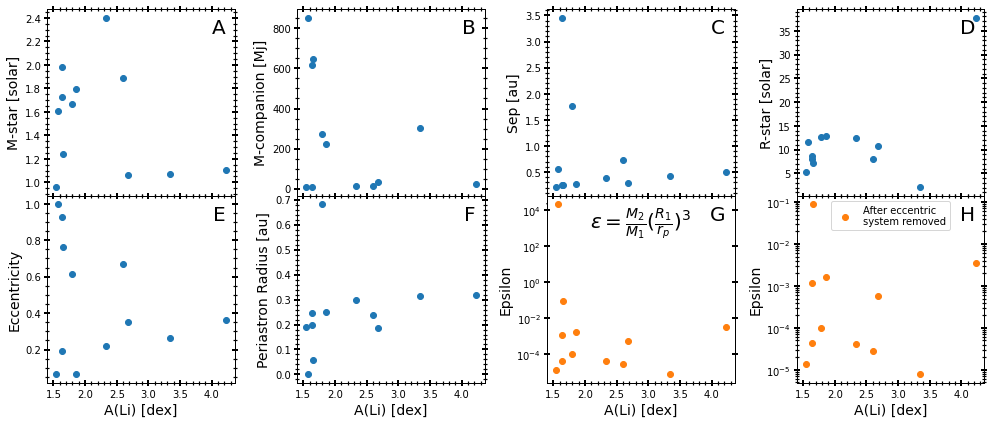

In [18]:

def peri_r(df):
    
    '''
    M1 : primary mass (ie. RG)
    M2 : companion mass
    R1 : primary radius (ie. RG)
    r  : periastron radius
    
    Dimensionless tidal amplitude parameter: 

    epsilon = (M_2/M_1)(R_1/r)^3

    Where R_1 is primary radius, 
    r is orbital separation (or distance at periastron), 
    M_2 is companion mass, M_1 is primary mass

    '''
    dfnew=df.copy()
    
    M1, M2 = df.m_act_bstep.to_numpy(), df.Mj50.to_numpy()
    a, e   = df.a50.to_numpy(), df.e50.to_numpy()
    R1     = df.radius_bstep.to_numpy()

    
    M1   = (M1*u.Msun).to(u.kg)
    M2   = (M2*u.Mjup).to(u.kg)
    a_au = (a*u.au)
    R1   = (R1*u.Rsun).to(u.au)
    r_p  = a_au*(1.-e)

    epsilon = (M2/M1)*(R1/r_p)**3.
    
    dfnew['epsilon'] = epsilon
    dfnew['rperi'] = r_p.value
    fig, ((ax1, ax2, ax3,ax4), (ax5,ax6,ax7, ax8)) = plt.subplots(2,4,figsize=(14,6))
    
    ax1.scatter(df.Li_val, df.m_act_bstep)
    ax2.scatter(df.Li_val, df.Mj50)
    ax3.scatter(df.Li_val, df.a50)
    ax4.scatter(df.Li_val, df.radius_bstep)
    ax5.scatter(df.Li_val, df.e50)
    ax6.scatter(df.Li_val, df.a50*(1-df.e50))
    ax7.scatter(df.Li_val, epsilon,c='C1')
    
    ax1.set_ylabel('M-star [solar]')
    ax2.set_ylabel('M-companion [Mj]')
    ax3.set_ylabel('Sep [au]')
    ax4.set_ylabel('R-star [solar]')
    ax5.set_ylabel('Eccentricity')
    ax6.set_ylabel('Periastron Radius [au]')
    ax7.set_ylabel('Epsilon')
    ax8.set_ylabel('Epsilon')
    
    ax7.set_yscale('log')
    
    mask = dfnew.epsilon<100
    ax8.scatter(dfnew[mask].Li_val, dfnew[mask].epsilon,label='After eccentric\nsystem removed',c='C1')
    ax8.legend(fontsize=10)
    ax8.set_yscale('log')
    
    for ax in [ax5,ax6,ax7, ax8]:
        ax.set_xlabel('A(Li) [dex]')
    from matplotlib import rc
    rc('text', usetex=False)
    formula = r'$\epsilon= \frac{M_2}{M_1} (\frac{R_1}{r_p} )^3$'
    
    ax7.text(0.5, 0.95, s=formula, transform=ax7.transAxes,fontsize=20, ha='center',va='top')
    
    for i,ax in zip('ABCDEFGH',[ax1,ax2,ax3,ax4,ax5,ax6,ax7, ax8]):
        ax.text(0.95, 0.95, s=i, transform=ax.transAxes,fontsize=20, ha='right',va='top')
        
    
    fig.tight_layout()
    plt.subplots_adjust(hspace=0)
#     plt.savefig('../plots/epsilon_%s.png'%DATE,bbox_inches='tight',dpi=200)
    return dfnew[['RG_id','program','m_act_bstep','radius_bstep','rperi','a50','e50','Mj50','epsilon','Li_val']].sort_values(by=['epsilon'])

peri_r(table4)

In [ ]:
def fitting(df):
    df = dfe[dfe.rperi<0.5]
    plt.scatter(df.Li_val, df.rperi)
fitting(dfe)

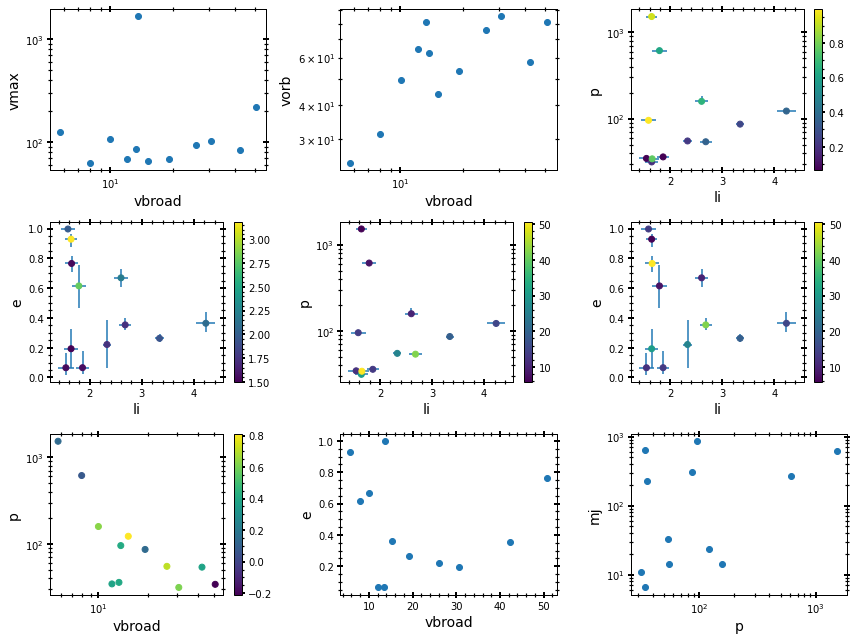

In [20]:
table3 = table4.copy() #table4[~((table4.RG_id==23) & (table4.program==112))]

plt.figure(figsize=(12,9))
plt.subplot(331)
plt.scatter(table3.vbroad,table3.v_max)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('vbroad')
plt.ylabel('vmax')

plt.subplot(332)
plt.scatter(table3.vbroad,table3.v_orb)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('vbroad')
plt.ylabel('vorb')

plt.subplot(333)
plt.errorbar(table3.Li_val, table3.P50, xerr=table3.e_Li_val,yerr=[table3.P50-table3.P16,table3.P84-table3.P50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.P50,c=table3.e50.to_numpy(),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('p')
plt.yscale('log')

plt.subplot(334)
plt.errorbar(table3.Li_val, table3.e50, xerr=table3.e_Li_val, yerr=[table3.e50-table3.e16,table3.e84-table3.e50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.e50,c=np.log10(table3.P50.to_numpy()),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('e')


plt.subplot(335)
plt.errorbar(table3.Li_val, table3.P50, xerr=table3.e_Li_val,yerr=[table3.P50-table3.P16,table3.P84-table3.P50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.P50,c=table3.vbroad.to_numpy(),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('p')
plt.yscale('log')


plt.subplot(336)
plt.errorbar(table3.Li_val, table3.e50, xerr=table3.e_Li_val, yerr=[table3.e50-table3.e16,table3.e84-table3.e50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.e50,c=table3.vbroad.to_numpy(),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('e')

plt.subplot(337)
plt.scatter(table3.vbroad, table3.P50,c=table3.Ba_fe)
plt.colorbar()
plt.xlabel('vbroad')
plt.ylabel('p')
plt.yscale('log')
plt.xscale('log')


plt.subplot(338)
plt.scatter(table3.vbroad, table3.e50)
plt.ylabel('e')
plt.xlabel('vbroad')


plt.subplot(339)
plt.scatter(table3.P50, (table3.Mj50*u.Mjup))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('mj')
plt.xlabel('p')

plt.tight_layout()

Text(0, 0.5, 'Period [days]')

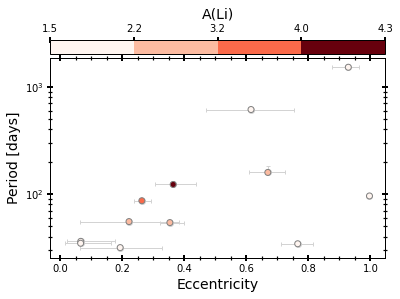

In [21]:
bounds = [1.5, 2.2, 3.2, 4, 4.3]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.e50, table3.P50,color='lightgrey', xerr=[table3.e50-table3.e16,table3.e84-table3.e50],
            yerr=[table3.P50-table3.P16,table3.P84-table3.P50],capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1)

im1=plt.scatter(table3.e50, table3.P50, c=table3.Li_val,cmap=cmap, norm=norm,ec='grey')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xlabel('Eccentricity')
ax1.set_ylabel('Period [days]')
# plt.savefig('../plots/e_P_li_%s.png'%DATE,bbox_inches='tight',dpi=200)


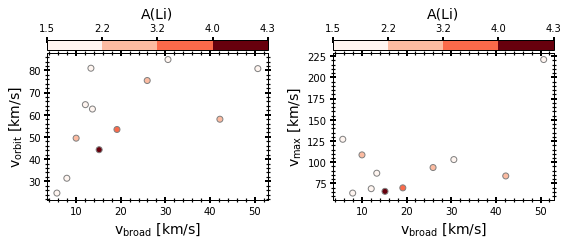

In [22]:

# a_all.v_max.to_numpy()[0].to(u.km/u.hour)
bounds = [1.5, 2.2, 3.2, 4, 4.3]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

plt.figure(figsize=(8,3.5))
ax1=plt.subplot(121)
im1=plt.scatter(table3.vbroad, table3.v_orb, c=table3.Li_val, cmap=cmap, norm=norm,ec='grey')
plt.xlabel('v$_\mathrm{broad}$ [km/s]')

plt.ylabel('v$_\mathrm{orbit}$ [km/s]')

line=np.linspace(min(table3.vbroad),max(table3.vbroad),1000)
# plt.plot(line,line,c='k')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax2=plt.subplot(122)
im2=plt.scatter(table3[table3.v_max<1000].vbroad,table3[table3.v_max<1000].v_max, c=table3[table3.v_max<1000].Li_val, cmap=cmap, norm=norm,ec='grey')
plt.xlabel('v$_\mathrm{broad}$ [km/s]')
plt.ylabel('v$_\mathrm{max}$ [km/s]')

ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax2.xaxis.set_ticks_position("top") # change tick position to top
cb2.ax.set_title(clabel)

# ax2.set_xscale('log')
# ax2.set_yscale('log')


plt.tight_layout()
# plt.savefig('../plots/vbroad_vmax_vorb_%s.png'%DATE,bbox_inches='tight',dpi=200)
plt.show()

(3.063198120106046, 61.2462833430784)

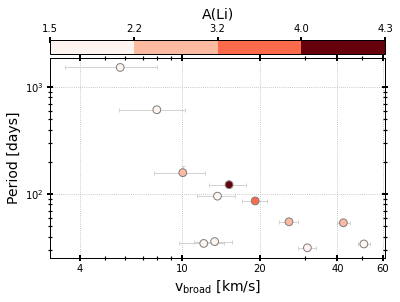

In [23]:
bounds = [1.5, 2.2, 3.2, 4, 4.3]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1,color='lightgrey')

im1=plt.scatter(table3.vbroad, table3.P50, c=table3.Li_val,cmap=cmap, norm=norm,ec='grey',s=60)

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xscale('log')
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)


ax1.set_xlabel('v$_{\mathrm{broad}}$ [km/s]')
ax1.set_ylabel('Period [days]')
ax1.grid(ls='dotted')
ax1.set_ylim(25.44715063069063, 1858.443368942767)
ax1.set_xlim(3.063198120106046, 61.2462833430784)

# plt.savefig('../plots/a1_%s.png'%DATE,bbox_inches='tight',dpi=200)


(3.063198120106046, 61.2462833430784)

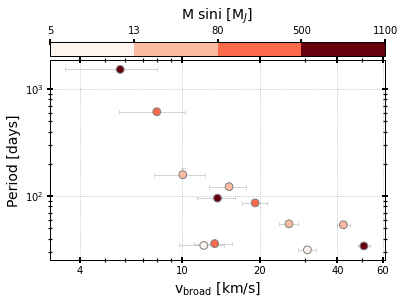

In [24]:
bounds = [5,13,80,500,1100]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'M sini [M$_J$]'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1,color='lightgrey')

im1=plt.scatter(table3.vbroad, table3.P50, c=table3.Mj50,cmap=cmap, norm=norm,ec='grey',s=60)

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xscale('log')
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)


ax1.set_xlabel('v$_{\mathrm{broad}}$ [km/s]')
ax1.set_ylabel('Period [days]')
ax1.grid(ls='dotted')
ax1.set_ylim(25.44715063069063, 1858.443368942767)
ax1.set_xlim(3.063198120106046, 61.2462833430784)

# plt.savefig('../plots/a2_%s.png'%DATE,bbox_inches='tight',dpi=200)


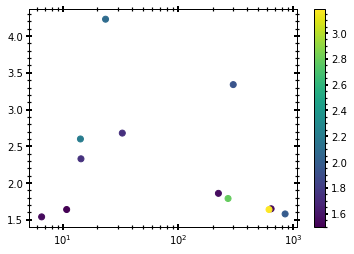

In [25]:
plt.scatter(table3.Mj50, table3.Li_val,c=np.log10(table3.P50))
plt.colorbar()
plt.xscale('log')

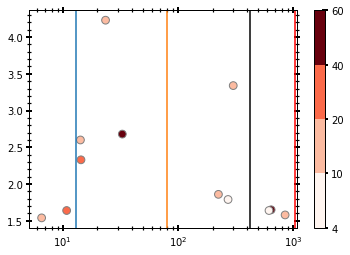

In [26]:
bounds = [0,0.25,0.5,0.75,1.]
bounds = [1.5, 2.2, 3.2, 4, 4.3]
bounds = [4,10,20,40,60]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'li'

plt.subplot(111)
plt.scatter(table3.Mj50, table3.Li_val,c=table3.vbroad,cmap=cmap,norm=norm,ec='grey',s=60)
plt.colorbar()
plt.xscale('log')
msolar = (u.Msun).to(u.Mjup)

plt.axvline(13,c='C0')
plt.axvline(80,c='C1')
plt.axvline(msolar,c='r')
plt.axvline(0.4*msolar,c='k')


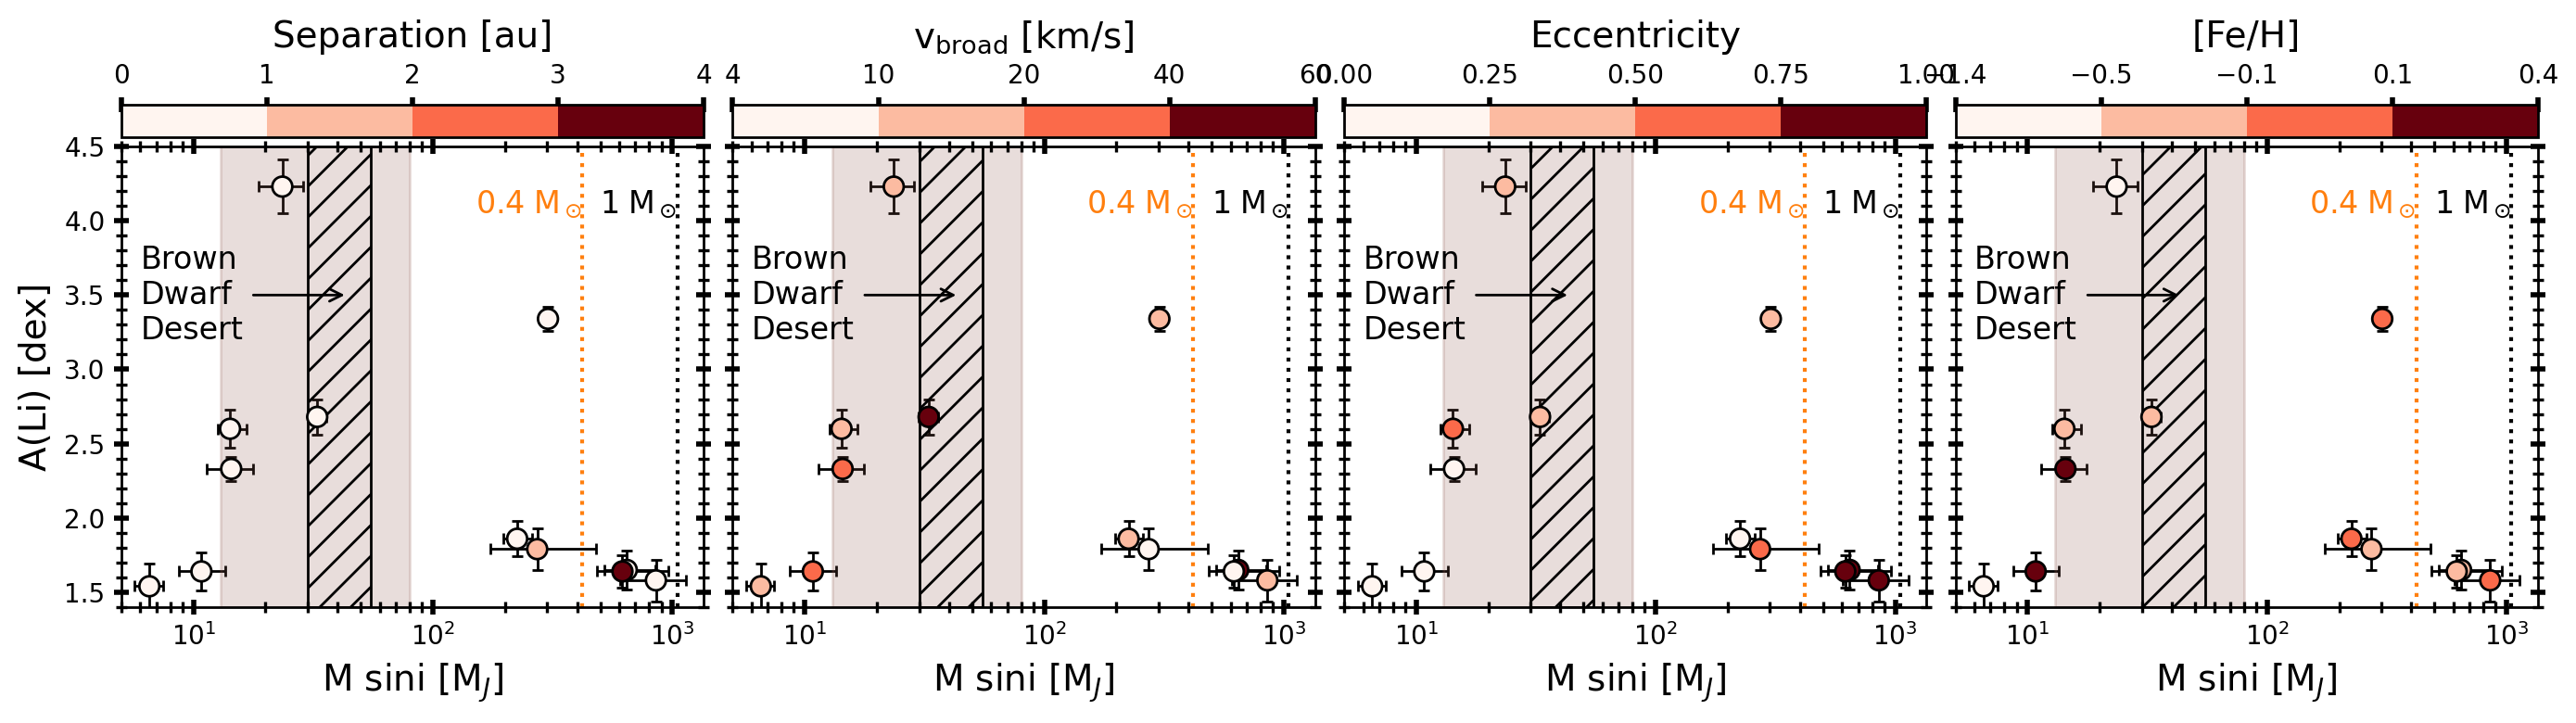

In [287]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14,4),dpi=200, sharex=True, sharey=True)

bounds = [0,1.0,2.0,3.0,4.0]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'Separation [au]'

im1=ax1.scatter(table3.Mj50, table3.Li_val,c=table3.a50,cmap=cmap,norm=norm,ec='k',s=60)
ax1.set_xscale('log')
ax1.set_ylabel('A(Li) [dex]')
ax1.set_xlabel('M sini [M$_J$]')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

# ax1=plt.subplot(132,sharex=ax1,sharey=ax1)
bounds = [4,10,20,40,60]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'v$_{\mathrm{broad}}$ [km/s]'

im2=ax2.scatter(table3.Mj50, table3.Li_val,c=table3.vbroad,cmap=cmap,norm=norm,ec='k',s=60)
ax2.set_xscale('log')

ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax2.xaxis.set_ticks_position("top") # change tick position to top
cb2.ax.set_title(clabel)
ax2.set_xlabel('M sini [M$_J$]')

bounds = [0,0.25,0.5,0.75,1.0]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'Eccentricity'

im3=ax3.scatter(table3.Mj50, table3.Li_val,c=table3.e50,cmap=cmap,norm=norm,ec='k',s=60)
ax3.set_xscale('log')

ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb3 = fig.colorbar(im3, cax=cax3, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax3.xaxis.set_ticks_position("top") # change tick position to top
cb3.ax.set_title(clabel)
ax3.set_xlabel('M sini [M$_J$]')

bounds = [-1.40,-0.5, -0.1,0.1, 0.4]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = '[Fe/H]'

im4=ax4.scatter(table3.Mj50, table3.Li_val,c=table3.fe_h,cmap=cmap,norm=norm,ec='k',s=60)
ax4.set_xscale('log')

ax4_divider = make_axes_locatable(ax4)
cax4 = ax4_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb4 = fig.colorbar(im4, cax=cax4, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax4.xaxis.set_ticks_position("top") # change tick position to top
cb4.ax.set_title(clabel)
ax4.set_xlabel('M sini [M$_J$]')

for ax in [ax1, ax2, ax3, ax4]:
    ax.errorbar(table3.Mj50, table3.Li_val, xerr=[table3.Mj50-table3.Mj16,table3.Mj84-table3.Mj50],yerr=table3.e_Li_val, fmt='o', color='k',lw=1, capsize=2, mec='None',mfc='None',zorder=-100)
    ax.axvspan(13, 80, color='tab:brown', alpha=0.2, label='Brown Dwarf',zorder=-100)
    ax.axvline(msolar,c='k',ls='dotted')
    ax.axvline(0.4*msolar,c='C1',ls='dotted')
    ax.text(msolar, 4.0, '$\mathrm{1 \; M_\odot}$',ha='right',fontsize=12, c='k', va='bottom')
    ax.text(0.4*msolar, 4.0, '$\mathrm{0.4 \; M_\odot}$',ha='right',fontsize=12, c='C1', va='bottom')
    ax.axvspan(30, 55, ec='k', hatch='//',fc='None',zorder=-100)
    
    ax.annotate("Brown\nDwarf\nDesert",  # Text to display
        xy=(45, 3.5),  # Point to annotate
        xytext=(6 ,3.5),  # Position of the text
        ha='left', va='center', fontsize=12,
        arrowprops=dict(arrowstyle="->", color="black"),  # Arrow properties
    )
ax1.set_ylim(1.4, 4.5)
ax1.set_xlim(5, 1350)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)

# plt.savefig('../plots/msini_vs_ali_mix_%s.png'%DATE,bbox_inches='tight',dpi=200)


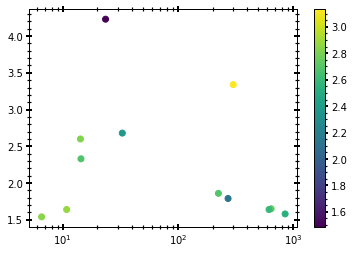

In [291]:

plt.scatter(table3.Mj50, table3.Li_val, c=table3.logg)
plt.colorbar()
plt.xscale('log')



In [295]:
table3[['RG_id','program','P50','e50','Li_val','vbroad','Mj50','a50','logg']].sort_values(by='logg')


,RG_id,program,P50,e50,Li_val,vbroad,Mj50,a50,logg
0,7,113,122.559742,0.364026,4.23,15.18,23.515823,0.498252,1.486652
0,6,112,614.328998,0.615072,1.79,7.95,272.611741,1.770096,2.119280
5,19,113,54.001598,0.353373,2.68,42.21,32.880137,0.287823,2.369927
4,18,113,95.724711,0.997206,1.58,13.68,853.484162,0.550684,2.532172
7,23,113,1525.611398,0.928916,1.64,5.73,618.600456,3.457470,2.588884
6,21,113,55.167827,0.221503,2.33,25.94,14.381805,0.382609,2.677707
3,23,112,36.052367,0.065884,1.86,13.34,224.823879,0.268446,2.683253
3,16,113,34.236376,0.765700,1.65,50.70,645.088524,0.254363,2.736165
1,7,112,158.760071,0.669294,2.60,10.03,14.229917,0.721416,2.817549
1,9,113,34.620994,0.065456,1.54,12.10,6.547777,0.205456,2.840097


(3.063198120106046, 61.2462833430784)

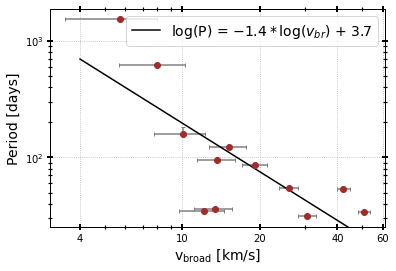

In [29]:
plt.figure(figsize=(6,4))
color='brown'
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             fmt='o',c='grey',mfc=color,mec=color,capsize=2)#,c=table3.Ba_fe)
# plt.colorbar()
plt.xlabel('v$_{\mathrm{broad}}$ [km/s]')
plt.ylabel('Period [days]')
plt.yscale('log')
plt.xscale('log')

def func(x, m, b):
    
    return m*x + b

from scipy.optimize import curve_fit

xdata,ydata = table3.vbroad.to_numpy(), table3.P50.to_numpy()
mask = np.argsort(xdata)
xdata,ydata = xdata[mask],ydata[mask]
xlog, ylog = np.log10(xdata),np.log10(ydata)
popt, pcov = curve_fit(func, xlog, ylog)

xvals = np.log10(np.linspace(4, 60, 100))
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)
plt.grid(ls='dotted')

plt.plot(10.**xvals, 10.**func(xvals, *popt), 'k-',
         label='log(P) = $%.1f*\log(v_{br}$) + %.1f' % tuple(popt))
# print(plt.ylim())
# print(plt.xlim())
plt.legend(loc='upper right')
plt.ylim(25.44715063069063, 1858.443368942767)
plt.xlim(3.063198120106046, 61.2462833430784)
# plt.savefig('../plots/b.png',bbox_inches='tight',dpi=200)

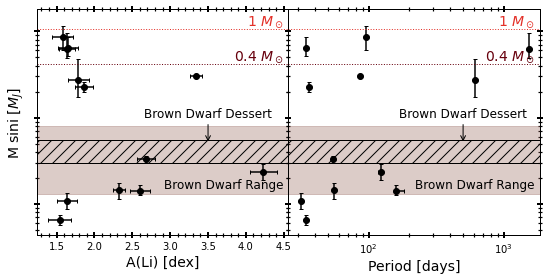

In [201]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax2.sharey(ax1)

ax1.errorbar(table3.Li_val, (table3.Mj50*u.Mjup), 
             xerr=table3.e_Li_val,
             yerr=[table3.Mj50-table3.Mj16,table3.Mj84-table3.Mj50],
             fmt='o',capsize=2, c='k')
ax1.set_yscale('log')
ax1.set_ylabel('M sini [$M_J$]')
ax1.set_xlabel('A(Li) [dex]')
ax1.set_ylim(4.4,1800)

ax2.errorbar(table3.P50, (table3.Mj50*u.Mjup), 
             xerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             yerr=[table3.Mj50-table3.Mj16,table3.Mj84-table3.Mj50],
             fmt='o',capsize=2, c='k')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Period [days]')

mearth = (u.Mjup).to(u.Mearth)
msolar = (u.Msun).to(u.Mjup)



for ax in [ax1,ax2]:

    ax.axhline(msolar,c=cmap(0.5),ls='dotted',lw=1,label='1 $M_\odot$')

    ax.axhline(0.4*msolar,c=cmap(0.75),ls='dotted',lw=1, label='0.4 $M_\odot$')
    
    ax.axhspan(13, 80, color='tab:brown', alpha=0.3, label='Brown Dwarf')
    
    ax.axhspan(30, 55, ec='k', hatch='//',zorder=100,fc='None')

xi = 4.5
ax1.text(xi, 20, s='Brown Dwarf Range', ha='right',va='top', c='k',fontsize=12)
ax1.text(xi, 0.4*msolar, s='0.4 $M_\odot$', ha='right',va='bottom', c=cmap(0.75),fontsize=14)
ax1.text(xi, msolar, s='1 $M_\odot$', ha='right',va='bottom', c=cmap(0.5),fontsize=14)
xi = 1700
ax2.text(xi, 20, s='Brown Dwarf Range', ha='right',va='top', c='k',fontsize=12)
ax2.text(xi, 0.4*msolar, s='0.4 $M_\odot$', ha='right',va='bottom', c=cmap(0.75),fontsize=14)
ax2.text(xi, msolar, s='1 $M_\odot$', ha='right',va='bottom', c=cmap(0.5),fontsize=14)

ax1.annotate("Brown Dwarf Dessert",  # Text to display
    xy=(3.5, 50),  # Point to annotate
    xytext=(3.5 ,100),  # Position of the text
    ha='center',fontsize=12,
    arrowprops=dict(arrowstyle="->", color="black"),  # Arrow properties
)

# ax2.axhline(msolar,c='r',ls='dotted',lw=1,label='1 $M_\odot$')
# ax2.text(xi, msolar, s='1 $M_\odot$', ha='right',va='bottom', c='r',fontsize=14)

# ax2.axhline(0.4*msolar,c='C0',ls='dotted',lw=1, label='0.4 $M_\odot$')
# ax2.text(xi, 0.4*msolar, s='0.4 $M_\odot$', ha='right',va='bottom', c='C0',fontsize=14)

# #plt.axhline(mearth,c='C1',ls='dotted',lw=1,label='1 $M_\oplus$')
# #plt.text(4.5, mearth, s='1 $M_\oplus$', ha='right',va='top', c='C1',fontsize=14)

# ax2.axhspan(13, 80, color='tab:brown', alpha=0.3, label='Brown Dwarf')

# ax2.axhspan(30, 55, ec='k', hatch='//',zorder=100,fc='None')

ax2.annotate("Brown Dwarf Dessert",  # Text to display
    xy=(500, 50),  # Point to annotate
    xytext=(500 ,100),  # Position of the text
    ha='center',fontsize=12,
    arrowprops=dict(arrowstyle="->", color="black"),  # Arrow properties
)

plt.tight_layout()

plt.subplots_adjust(wspace=0)

ax2.set_yticklabels([])

# plt.savefig('../plots/msini_%s.png'%DATE,bbox_inches='tight',dpi=200)

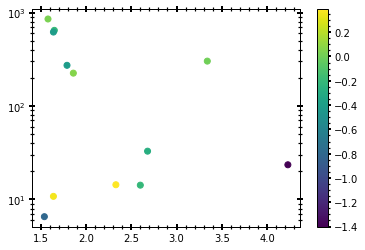

In [204]:
plt.scatter(table3.Li_val, (table3.Mj50*u.Mjup), c=table3.fe_h)
plt.yscale('log')
plt.colorbar()

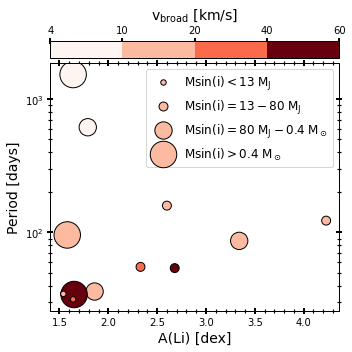

In [146]:
bounds = [4,10,20,40,60]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'v$_{\mathrm{broad}}$ [km/s]'
print

real_size  = table3.Mj50.to_numpy()
mask0 = (real_size < 13)
mask1 = ((real_size >= 13) & (real_size < 80))
mask2 = ((real_size >= 80) & (real_size < 0.4*msolar))
mask3 = (real_size >= 0.4*msolar)

dummy_size = np.zeros(len(real_size))
dummy_size[mask0] = 30
dummy_size[mask1] = 80
dummy_size[mask2] = 300
dummy_size[mask3] = 700

plt.figure(figsize=(5,5))

ax=plt.subplot(111)
im = plt.scatter(table3.Li_val, table3.P50, s= dummy_size,ec='k', c=table3.vbroad,cmap=cmap,norm=norm)
plt.scatter(table3[mask0].Li_val, table3[mask0].P50, s= dummy_size[mask0],ec='k', c=table3[mask0].vbroad,cmap=cmap,norm=norm)
lgnd = [Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(30),ls='',label='$\mathrm{M \sin(i) < 13 \; M_J}$'), 
        Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(80),ls='',label='$\mathrm{M \sin(i) = 13-80 \; M_J}$'), 
        Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(300),ls='',label='$\mathrm{M \sin(i) = 80 \; M_J - 0.4 \; M_\odot}$'), 
        Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(700),ls='',label='$\mathrm{M \sin(i) > 0.4 \; M_\odot}$'), 
       ]
ax.legend(handles=lgnd,fontsize=12)

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb = fig.colorbar(im, cax=cax, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax.xaxis.set_ticks_position("top") # change tick position to top
cb.ax.set_title(clabel)

ax.set_yscale('log')
ax.set_xlabel('A(Li) [dex]')
ax.set_ylabel('Period [days]')
plt.tight_layout()

# plt.savefig('../plots/p_vs_li_size_%s.png'%DATE,bbox_inches='tight',dpi=200)

In [33]:
def clean_up(df):
    time = df['comb_time']
    rv = df['comb_rv']
    err = df['comb_rv_err']
    
    time = time.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    time = [t for t in time if len(t) > 0]
    time = [float(t.split('\n')[0]) for t in time]
    
    rv = rv.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    rv = [t for t in rv if len(t) > 0]
    rv = [float(t.split('\n')[0]) for t in rv]
    
    err = err.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    err = [t for t in err if len(t) > 0]
    err = [float(t.split('\n')[0]) for t in err]
    
    return time, rv, err

clean_up(rv_df[(rv_df.RG_id==1) & (rv_df.program==112)])


([2460341.53519178,
  2460389.56581584,
  2460371.51348333,
  2460303.84853621,
  2457030.1328125],
 [53.7010931, 53.79850384, 53.71577284, 53.45877222, 53.57600021],
 [0.03563532, 0.0194216, 0.01884311, 0.00615718, 0.071])

In [34]:
def plot_joker_samples(df, obj, program, ax, version=1):
#     if (obj==16 or obj==11) and program=='p113':
#         version = 2
#     else:
    dftemp  = df[(df.RG_id==obj) & (rv_df.program==program)]

    fname   = '../mcmc/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    
    time, rv, rv_err = clean_up(dftemp)
    
    data = Table()
    data['bjd']     = time
    data['rv']      = rv
    data['rv_err']  = rv_err
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s
    
    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))
    PLOT_PARAMS()

    _ = tj.plot_rv_curves(joker_samples, data=data, ax=ax)
    if program==112:
        ax.text(0.5, 0.9, '112 - RG %s'%obj, transform=ax.transAxes,fontsize=14, ha='center')
    else:
        ax.text(0.5, 0.9, '113 - RG %s'%obj, transform=ax.transAxes,fontsize=14, ha='center',)
    


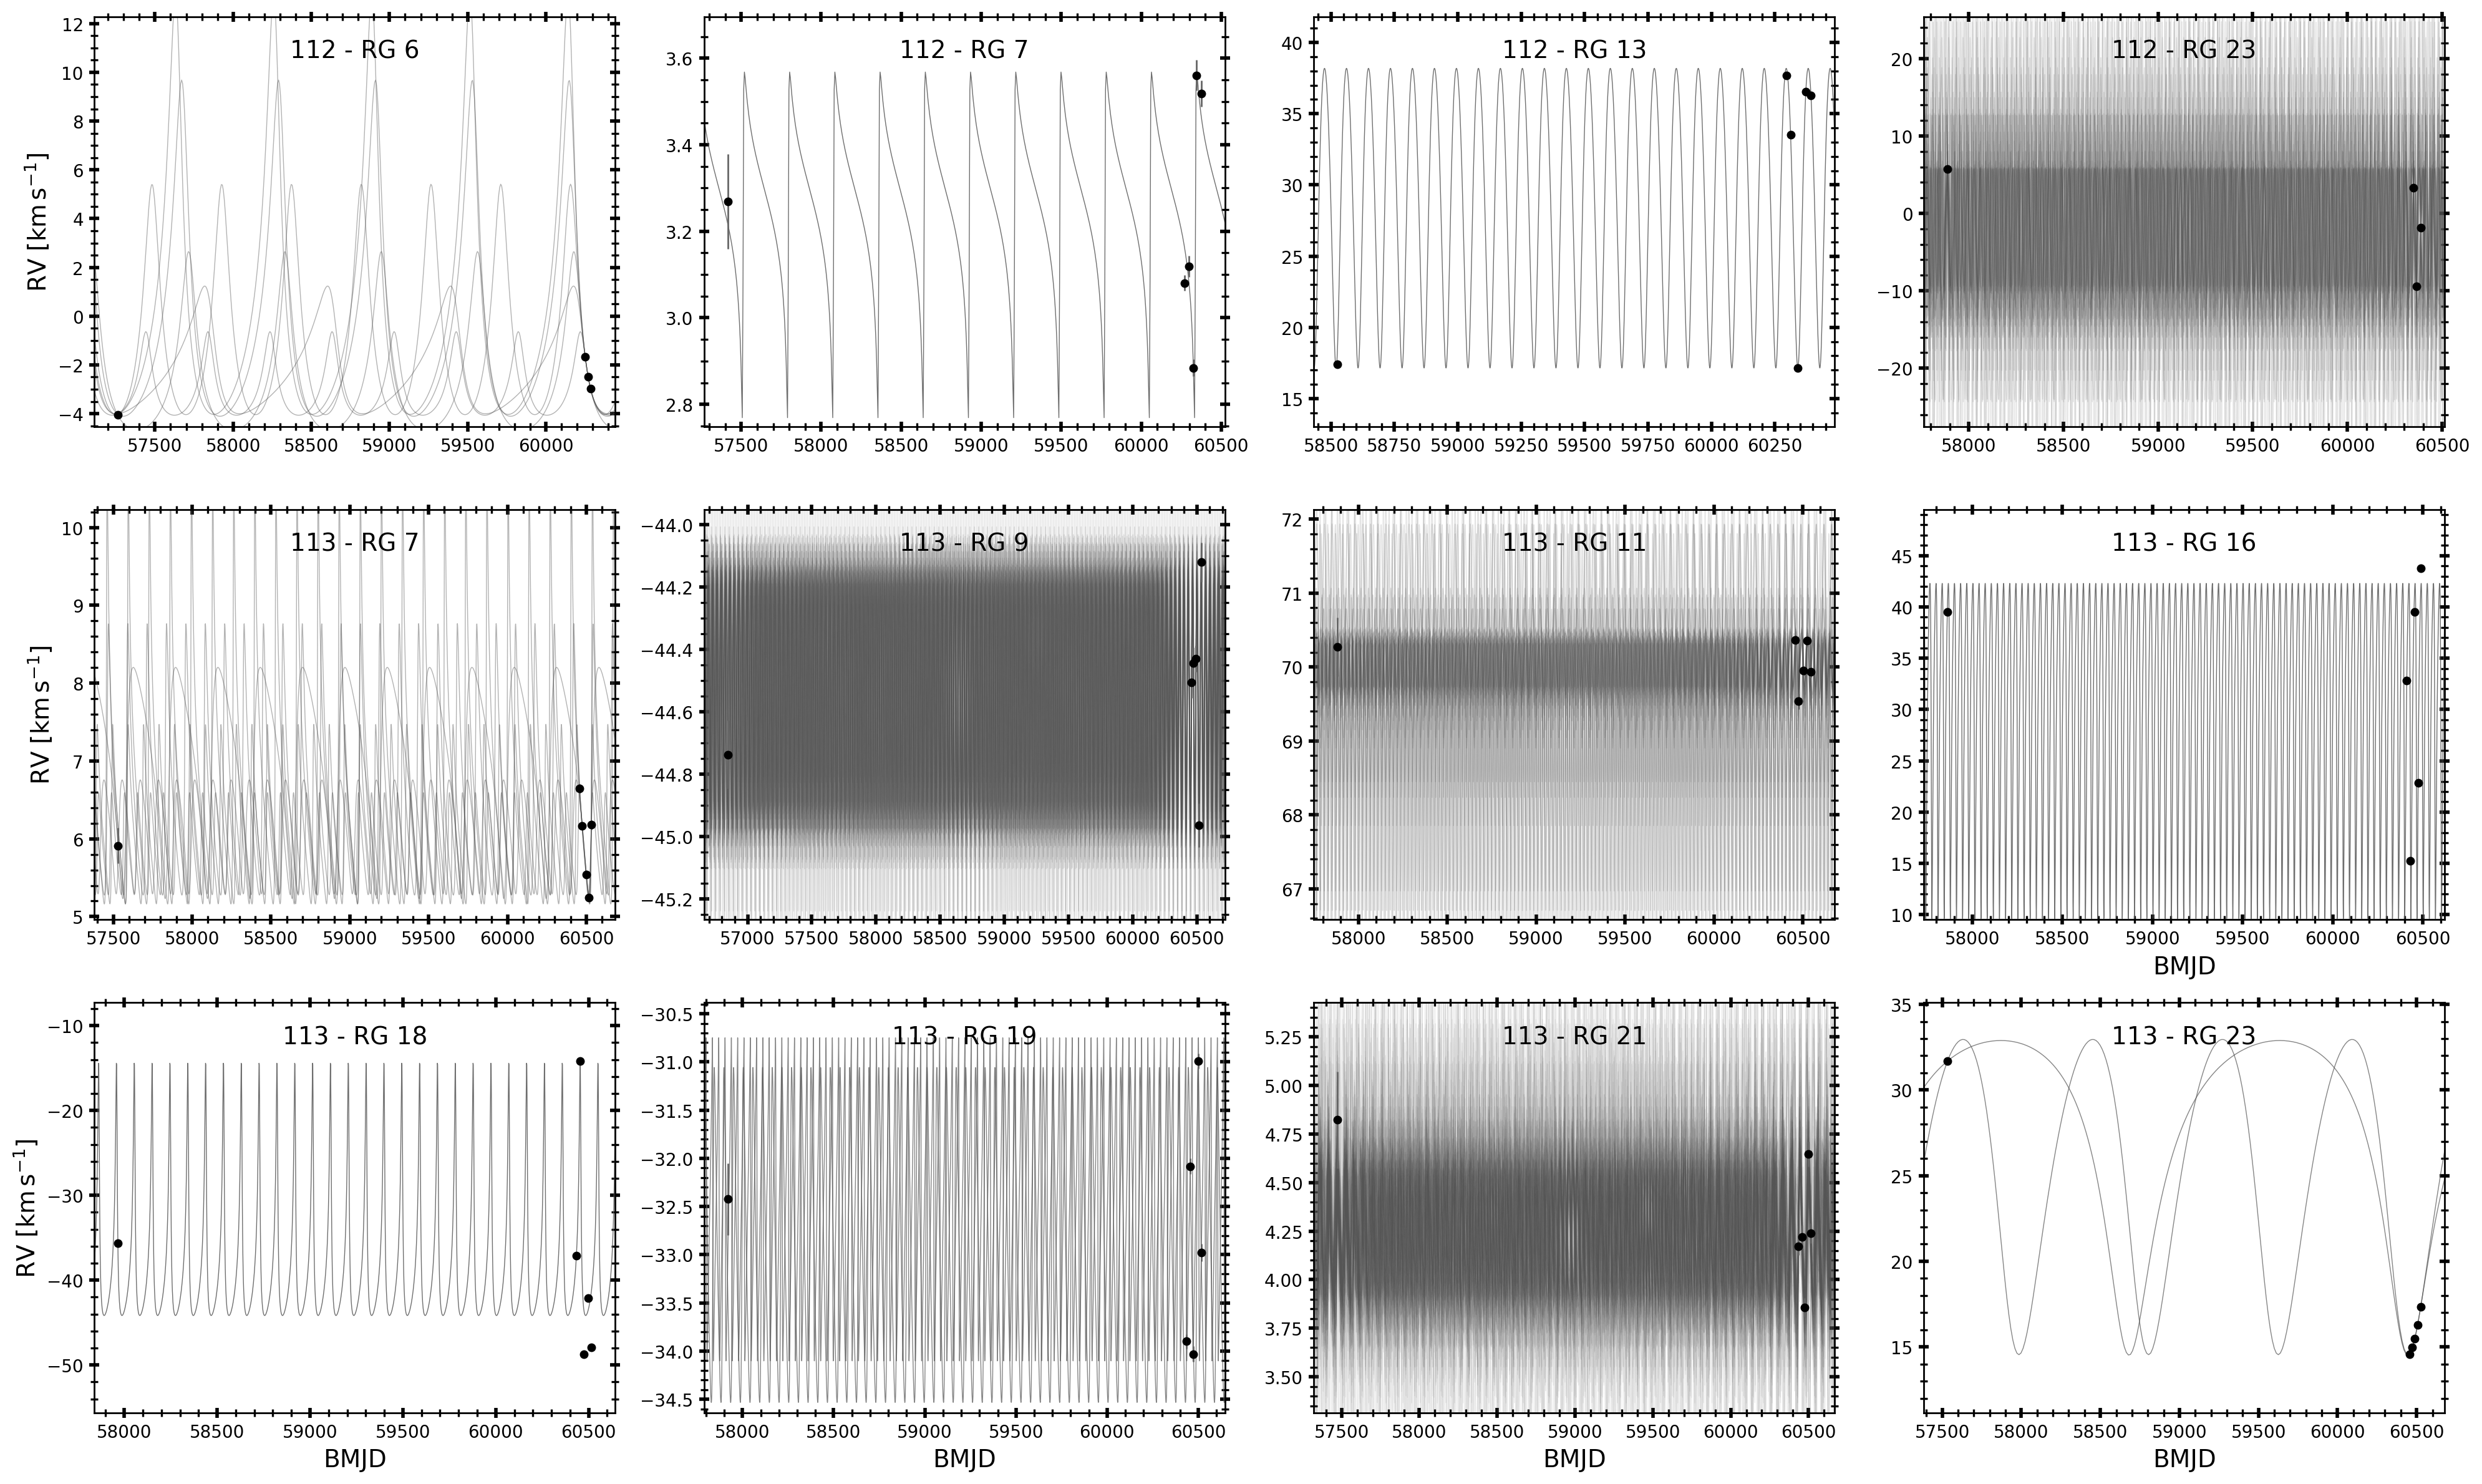

In [35]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12),dpi=200)

for i, ax in enumerate(fig.axes):

    if i < len(binary_list_112):
        obj = binary_list_112[i]
        plot_joker_samples(rv_df, obj, program=112, ax=ax)
    elif i >= len(binary_list_112):
        obj = binary_list_113[i-len(binary_list_112)]
        plot_joker_samples(rv_df, obj, program=113, ax=ax)
    if i<7:
        ax.xaxis.label.set_visible(False)

        #ax.tick_params(axis='both', bottom=False, labelbottom=False)
    if i not in [0,4,8]:
        ax.yaxis.label.set_visible(False)
        #ax.tick_params(axis='both', left=False, labelleft=False)

plt.tight_layout()
# plt.savefig('../plots/all_joker_samples_%s.png'%DATE,bbox_inches='tight',dpi=200)


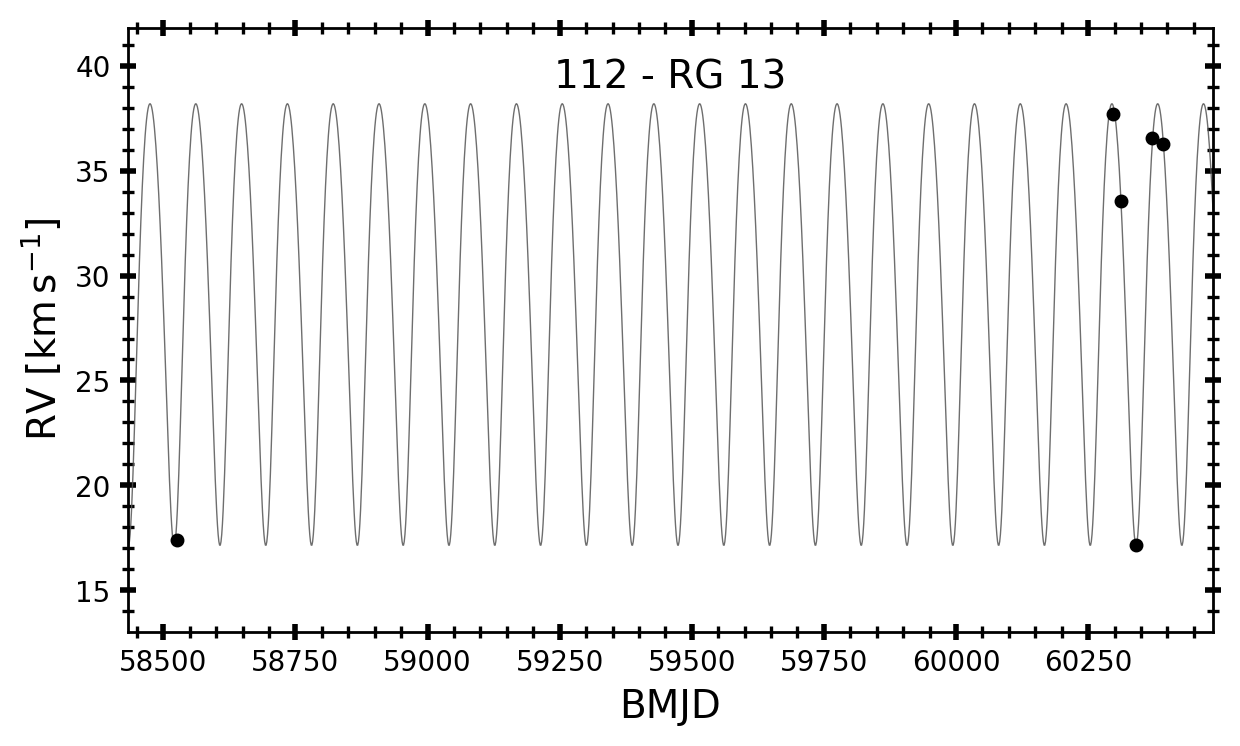

In [36]:
fig=plt.figure(figsize=(7,4),dpi=200)
ax=plt.subplot(111)
plot_joker_samples(rv_df, 13, program=112, ax=ax)

In [37]:
table3[['RG_id','program','vbroad','Li_val','e50','P50','Mj50']].sort_values(by='Li_val')

,RG_id,program,vbroad,Li_val,e50,P50,Mj50
1,9,113,12.10,1.54,0.065456,34.620994,6.547777
4,18,113,13.68,1.58,0.997206,95.724711,853.484162
2,11,113,30.59,1.64,0.193047,31.517923,10.801213
7,23,113,5.73,1.64,0.928916,1525.611398,618.600456
3,16,113,50.70,1.65,0.765700,34.236376,645.088524
0,6,112,7.95,1.79,0.615072,614.328998,272.611741
3,23,112,13.34,1.86,0.065884,36.052367,224.823879
6,21,113,25.94,2.33,0.221503,55.167827,14.381805
1,7,112,10.03,2.60,0.669294,158.760071,14.229917
5,19,113,42.21,2.68,0.353373,54.001598,32.880137


In [38]:
table3[['RG_id','program','vbroad','Li_val','e50','P50','Mj50','v_max']].sort_values(by='e50')

,RG_id,program,vbroad,Li_val,e50,P50,Mj50,v_max
1,9,113,12.10,1.54,0.065456,34.620994,6.547777,68.844472
3,23,112,13.34,1.86,0.065884,36.052367,224.823879,87.079808
2,11,113,30.59,1.64,0.193047,31.517923,10.801213,103.141704
6,21,113,25.94,2.33,0.221503,55.167827,14.381805,93.761645
2,13,112,19.17,3.34,0.263000,86.425657,302.364458,69.806988
5,19,113,42.21,2.68,0.353373,54.001598,32.880137,83.836854
0,7,113,15.18,4.23,0.364026,122.559742,23.515823,65.671571
0,6,112,7.95,1.79,0.615072,614.328998,272.611741,63.663767
1,7,112,10.03,2.60,0.669294,158.760071,14.229917,108.666543
3,16,113,50.70,1.65,0.765700,34.236376,645.088524,221.046559


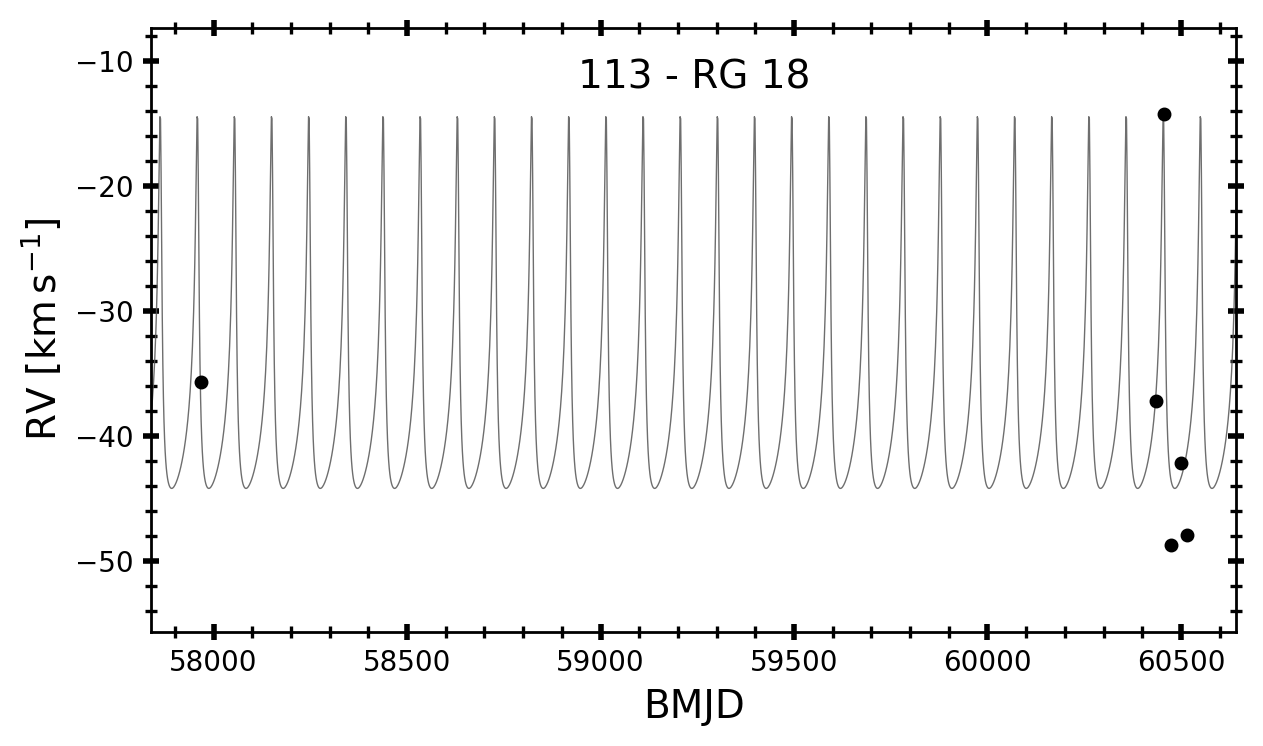

In [39]:
fig=plt.figure(figsize=(7,4),dpi=200)
ax=plt.subplot(111)
plot_joker_samples(rv_df, 18, program=113, ax=ax)

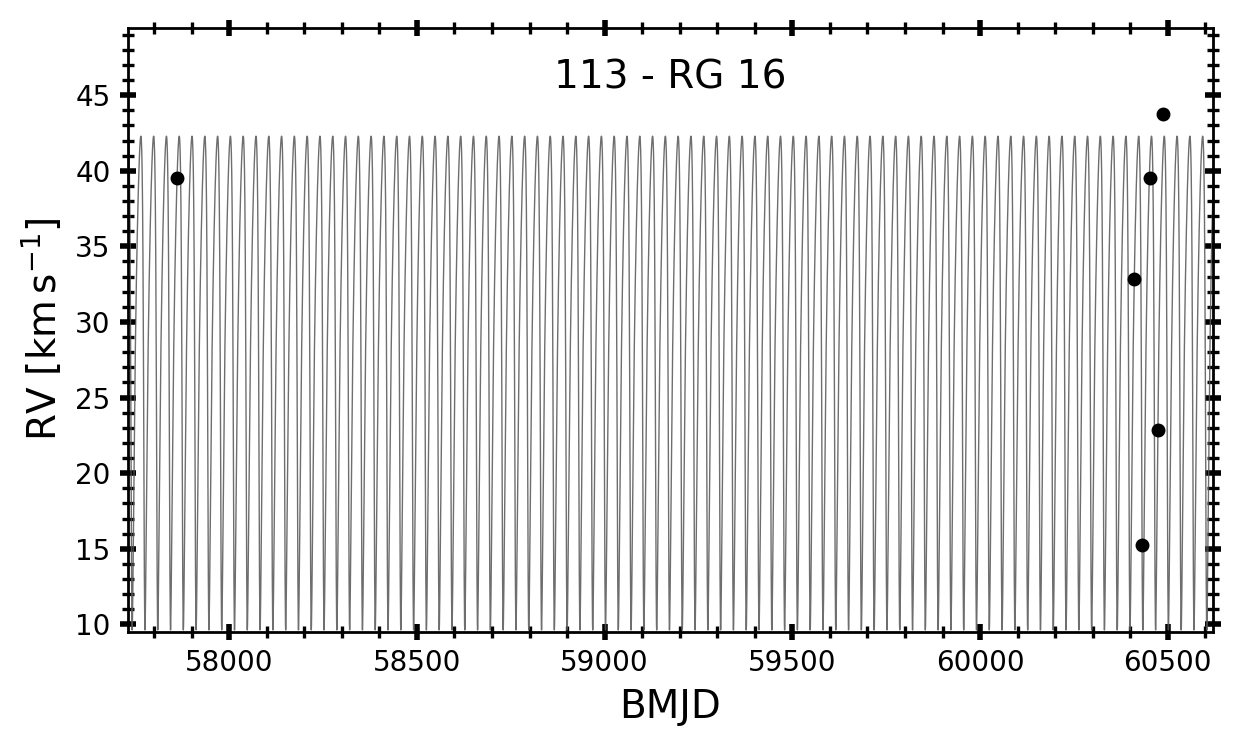

In [40]:
fig=plt.figure(figsize=(7,4),dpi=200)
ax=plt.subplot(111)
plot_joker_samples(rv_df, 16, program=113, ax=ax)

8

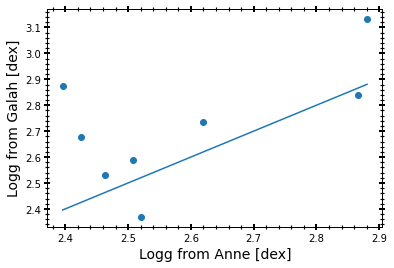

In [41]:
d1 = Table.read('../files/espresso_final_result.fits').to_pandas()
d2 = pd.merge(d1, table3, left_on='sobject_id',right_on='sobject_id')#.keys()
plt.figure()

plt.scatter(d2.logg_c, d2.logg_x)
plt.xlabel('Logg from Anne [dex]')
plt.ylabel('Logg from Galah [dex]')
line=np.linspace(min(d2.logg_c), max(d2.logg_c),1000)
plt.plot(line,line)
len(d2)

In [ ]:
mass, a, rstar, e

peri = a*(1-e)


tides = table3.Mj50/(Mstar) * (Rs/peri)**3



In [ ]:
# plt.scatter(d2.logg_x, d2.Li_val_x)
plt.figure(dpi=150)
plt.scatter(d2.logg_c, d2.Li_val_x)
plt.xlabel('Logg from Anne [dex]')
plt.ylabel('A(Li)')

In [ ]:
len(rv_df)
plt.figure(figsize=(6,4))
# plt.hist(rv_df.Li_val,bins=np.arange(1.5,4.5,0.5),color='lightgrey',zorder=-100)
plt.hist(rv_df.Li_val,bins=np.arange(1.5,4.5,0.5),histtype='step',color='k')

plt.hist(rv_df[(rv_df.RG_id.isin(binary_list_112)) & (rv_df.program==112)].Li_val,bins=np.arange(1.5,4.5,0.5),ec='k',histtype='step')
plt.hist(rv_df[(rv_df.RG_id.isin(binary_list_112)) & (rv_df.program==112)].Li_val,bins=np.arange(1.5,4.5,0.5),color=color)


plt.hist(rv_df[(rv_df.RG_id.isin(binary_list_113)) & (rv_df.program==113)].Li_val,bins=np.arange(1.5,4.5,0.5),ec='k',histtype='step')
plt.hist(rv_df[(rv_df.RG_id.isin(binary_list_113)) & (rv_df.program==113)].Li_val,bins=np.arange(1.5,4.5,0.5),color=color)


In [ ]:
# pd.read_pickle("../data/gfinal_rich_low_fidelity.pkl")
    #dfr = dfr[~dfr.sobject_id.isin(df_rich.sobject_id)]
df_rich = pd.read_pickle('../../lithium/data/gfinal_rich.pkl')#.to_pandas()
df_rich

In [ ]:
vac = pd.merge(df_rich, galah_vac, on='sobject_id')


In [ ]:
np.nanmean(np.array(vac.e_m_act_bstep/vac.m_act_bstep)),np.nanmax(np.array(vac.e_m_act_bstep/vac.m_act_bstep))

In [ ]:
np.nanmean(np.array(vac.e_age_bstep/vac.age_bstep)),np.nanmin(np.array(vac.e_age_bstep/vac.age_bstep)),np.nanmax(np.array(vac.e_age_bstep/vac.age_bstep))